## ALS implementation using Spark for Movie Recommendation

Install Basic Libraries

Import basic spark libraries

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
spark = SparkSession.builder.appName("als").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load Movie Ratings Data

In [7]:
ratings = spark.read.csv("s3a://sparkdemonstration-mlc/ratings.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
ratings.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows

In [8]:
ratings.head(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(userId=1, movieId=296, rating=5.0, timestamp=1147880044), Row(userId=1, movieId=306, rating=3.5, timestamp=1147868817), Row(userId=1, movieId=307, rating=5.0, timestamp=1147868828), Row(userId=1, movieId=665, rating=5.0, timestamp=1147878820), Row(userId=1, movieId=899, rating=3.5, timestamp=1147868510), Row(userId=1, movieId=1088, rating=4.0, timestamp=1147868495), Row(userId=1, movieId=1175, rating=3.5, timestamp=1147868826), Row(userId=1, movieId=1217, rating=3.5, timestamp=1147878326), Row(userId=1, movieId=1237, rating=5.0, timestamp=1147868839), Row(userId=1, movieId=1250, rating=4.0, timestamp=1147868414)]

In [9]:
ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25000095

In [10]:
ratings.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+------------------+--------------------+
|summary|           userId|           movieId|            rating|           timestamp|
+-------+-----------------+------------------+------------------+--------------------+
|  count|         25000095|          25000095|          25000095|            25000095|
|   mean|81189.28115381162|21387.981943268616| 3.533854451353085|1.2156014431215513E9|
| stddev|46791.71589745707|39198.862101060215|1.0607439611423508|2.2687580805953684E8|
|    min|                1|                 1|               0.5|           789652009|
|    max|           162541|            209171|               5.0|          1574327703|
+-------+-----------------+------------------+------------------+--------------------+

## Visualize ratings data in Rating Matrix format

In [11]:
rating_small = spark.read.csv("s3a://sparkdemonstration-mlc/ratings_small.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
rating_small.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

40

In [13]:
rating_small.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|  6947|     11|   2.0|1130275865|
|  6947|     19|   3.5|1130275926|
|  6947|    410|   1.5|1130275858|
|  6947|    442|   3.5|1130275932|
|  6947|    474|   4.0|1130275893|
|  6947|    708|   2.5|1130275957|
|  6947|    786|   2.5|1130275936|
|  6947|    912|   5.0|1130275870|
|  6947|   1221|   5.0|1130275875|
|  6947|   1307|   3.5|1130275904|
|  6947|   1527|   4.0|1130275882|
|  6947|   1610|   4.0|1130275942|
|  6947|   1784|   4.0|1130275929|
|  6947|   1923|   4.0|1130275901|
|  6947|   1961|   4.0|1130275896|
|  6947|   2987|   3.5|1130275959|
|  6947|   2997|   4.5|1130275890|
|  6947|   4306|   3.5|1130275951|
|  6947|   4993|   5.0|1130275944|
|  6947|  36529|   3.0|1130276051|
+------+-------+------+----------+
only showing top 20 rows

### Load Movies Data

In [14]:
movies = spark.read.csv("s3a://sparkdemonstration-mlc/movies.csv",inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
movies.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [16]:
movies.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

62423

### Split the Rating data to Train & Test set

In [17]:
(training, validation, test) = ratings.randomSplit([0.6, 0.2, 0.2], seed=99)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
training.count(), test.count(), validation.count(),ratings.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14997545, 5001359, 4999424, 25000095)

## ALS Model

Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

In [19]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=5, regParam=0.05, coldStartStrategy="drop")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Training

In [20]:
als

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ALS_46547ae1d805

In [21]:
model=als.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
prediction=model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
prediction.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
| 99010|    148|   3.0| 837652881| 2.7796779|
| 57779|    148|   2.0| 835816780|  2.345887|
|145182|    148|   3.0| 944952722|  2.665872|
| 69123|    148|   4.5|1086929593| 2.2994277|
| 73977|    148|   2.0| 965106877| 3.3122435|
|110863|    148|   3.0| 832312374| 2.7154894|
|114572|    148|   2.0| 838460783| 2.3427248|
|124207|    148|   3.0| 847246861| 1.5648663|
|159730|    148|   3.0| 842162037| 2.7180588|
|154493|    148|   3.0| 847089543| 2.3510308|
|  6491|    148|   4.0|1500217059|  2.788311|
| 14831|    148|   3.0| 944148276| 2.6185567|
| 92046|    148|   3.0|1021775913|  2.569989|
| 48928|    148|   2.0| 974930221| 2.2537959|
| 91345|    148|   3.0| 834673760|  2.439394|
|118962|    148|   3.0| 877536496| 2.3433511|
| 20528|    148|   3.0| 830778220| 2.4396758|
| 78299|    148|   2.0| 844627287| 1.5118791|
|134649|    148|   3.0|1146472014|

## Calculate the RMSE error

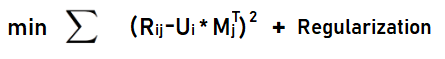

Evaluate the model by computing the RMSE on the test data

In [24]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
rmse = evaluator.evaluate(prediction) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
rmse

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8104774921521035

In [27]:
iter_array=[1,3,5,7]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
rmse_list=[]
for val in iter_array :
  print("val",val)
  als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=val, regParam=0.05, coldStartStrategy="drop")
  model=als.fit(training)
  prediction=model.transform(validation)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
  rmse = evaluator.evaluate(prediction) 
  rmse_list.append(rmse)
  print("rmse",rmse)
  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

val 1
rmse 3.3011734959468
val 3
rmse 0.8370451039941761
val 5
rmse 0.81093995827156
val 7
rmse 0.8034775024096463

## How to Choose optimal maxIter value

While training the model we've used maxIter value as 5<br>which means there will be 5 iterations of the complete model to get the least error.<br>
Its possible that we can get most optimal model is less than 5 or more then 5 iterations.<br>
You have seen in the video that the iteration **value = 3** is optimal value to train the model.


We can not run the python commands here when we set the kernel as PySpark to plot the graph between number of iterations and RMSE values.

## Now train Model with most optimal maxIter value

In [30]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",maxIter=3, regParam=0.05, coldStartStrategy="drop")
model=als.fit(training)
prediction=model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(prediction) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Generate top 10 User Recommendation for a Movie

In [31]:
prediction.show()                                           

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|114572|    148|   2.0| 838460783|  2.086742|
|124207|    148|   3.0| 847246861| 1.4195833|
|159730|    148|   3.0| 842162037| 2.8210564|
| 99010|    148|   3.0| 837652881| 2.3997452|
|  6491|    148|   4.0|1500217059| 2.2282453|
| 84667|    148|   5.0| 832207176| 3.0726292|
| 75209|    148|   2.0|1361853682| 1.4788227|
| 57779|    148|   2.0| 835816780|  2.162384|
|109156|    148|   2.0| 989289917| 2.5131047|
| 19478|    148|   2.0| 954478151| 2.5637102|
| 58005|    148|   3.0|1112745159| 2.4548206|
| 14831|    148|   3.0| 944148276| 2.4536567|
| 68262|    148|   4.0| 942234567| 3.2414603|
| 91265|    148|   4.0| 836315177|  2.517717|
|154493|    148|   3.0| 847089543| 2.3402753|
| 92046|    148|   3.0|1021775913| 2.2480388|
|  7836|    148|   3.0| 842266581| 2.5540087|
|138583|    148|   2.0| 880550880| 2.5787435|
|145182|    148|   3.0| 944952722|

In [32]:
movies_reco=model.recommendForAllItems(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
movies_reco.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    148|[[16331, 4.808739...|
|    463|[[12810, 5.256575...|
|    471|[[48436, 5.349968...|
|    496|[[68990, 6.095554...|
|    833|[[26659, 5.186154...|
|   1088|[[42807, 5.939224...|
|   1238|[[140441, 5.42793...|
|   1342|[[140901, 5.77865...|
|   1580|[[127639, 5.64917...|
|   1591|[[94871, 5.330189...|
|   1645|[[58129, 5.631418...|
|   1829|[[109853, 5.61671...|
|   1959|[[96262, 5.549501...|
|   2122|[[160195, 6.06824...|
|   2142|[[82361, 5.277450...|
|   2366|[[6160, 6.0239935...|
|   2659|[[26659, 5.527042...|
|   2866|[[74833, 5.348984...|
|   3175|[[74833, 5.451265...|
|   3749|[[89889, 6.719330...|
+-------+--------------------+
only showing top 20 rows

In [34]:
movies_joined=movies_reco.join(movies,on="movieId",how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Join with the Movies data

In [35]:
movies_joined.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+--------------------+
|movieId|     recommendations|               title|              genres|
+-------+--------------------+--------------------+--------------------+
|    148|[[16331, 4.808739...|Awfully Big Adven...|               Drama|
|    463|[[12810, 5.256575...|Guilty as Sin (1993)|Crime|Drama|Thriller|
|    471|[[48436, 5.349968...|Hudsucker Proxy, ...|              Comedy|
|    496|[[68990, 6.095554...|What Happened Was...|Comedy|Drama|Roma...|
|    833|[[26659, 5.186154...|High School High ...|              Comedy|
|   1088|[[42807, 5.939224...|Dirty Dancing (1987)|Drama|Musical|Rom...|
|   1238|[[140441, 5.42793...|   Local Hero (1983)|              Comedy|
|   1342|[[140901, 5.77865...|     Candyman (1992)|     Horror|Thriller|
|   1580|[[127639, 5.64917...|Men in Black (a.k...|Action|Comedy|Sci-Fi|
|   1591|[[94871, 5.330189...|        Spawn (1997)|Action|Adventure|...|
|   1645|[[58129, 5.631418...|The Devil's Advoc...|

In [36]:
x=movies_joined.head(1)[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
x['movieId']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148

In [39]:
x['recommendations']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(userId=16331, rating=4.80873966217041), Row(userId=1571, rating=4.517165184020996), Row(userId=50936, rating=4.466872692108154), Row(userId=147970, rating=4.465632438659668), Row(userId=85184, rating=4.452655792236328), Row(userId=72047, rating=4.44678258895874), Row(userId=72715, rating=4.3974690437316895), Row(userId=142300, rating=4.388278484344482), Row(userId=112655, rating=4.343882083892822), Row(userId=90581, rating=4.332155704498291)]

## Generate top 10 Recommended Movies for all the Users

In [41]:
users_reco=model.recommendForAllUsers(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
users_reco.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[159467, 10.6479...|
|   463|[[205277, 13.4956...|
|   471|[[205277, 11.3074...|
|   496|[[159467, 12.8226...|
|   833|[[205277, 9.64589...|
|  1088|[[192689, 11.1298...|
|  1238|[[205277, 11.7465...|
|  1342|[[159467, 10.1648...|
|  1580|[[205277, 11.4177...|
|  1591|[[205277, 14.1689...|
|  1645|[[205277, 10.8279...|
|  1829|[[205277, 10.5778...|
|  1959|[[205277, 12.3867...|
|  2122|[[126941, 9.52316...|
|  2142|[[205277, 11.1010...|
|  2366|[[159467, 10.8546...|
|  2659|[[151410, 11.4526...|
|  2866|[[202231, 10.9842...|
|  3175|[[205277, 10.8023...|
|  3749|[[187999, 9.77896...|
+------+--------------------+
only showing top 20 rows

In [44]:
users_reco.toPandas().to_csv("movies_reco")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pandas >= 0.19.2 must be installed; however, it was not found.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py", line 2076, in toPandas
    require_minimum_pandas_version()
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 129, in require_minimum_pandas_version
    "it was not found." % minimum_pandas_version)
ImportError: Pandas >= 0.19.2 must be installed; however, it was not found.



In [45]:
top_movies=prediction.orderBy('prediction',ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
top_movies.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
| 84048| 167072|   5.0|1493789989|  9.559221|
| 50827| 179405|   3.5|1520280437|  8.909317|
| 57159|  26968|   3.5|1491566388|  8.750888|
| 55578| 154860|   0.5|1514842755|  8.531473|
|  5202| 134627|   4.5|1433668802|  8.366497|
| 41910| 187549|   4.5|1542468817|   8.34366|
| 56927| 127222|   4.5|1422724164|  8.089549|
|155439| 189501|   4.5|1528305705|  8.001777|
|149113| 147621|   5.0|1511027664|  7.970249|
|154858| 203771|   4.5|1562384974|  7.946013|
|130843| 187169|   4.0|1561324415| 7.8644056|
| 26043| 148484|   1.0|1449759508|  7.817319|
| 71088| 178877|   4.5|1509221233| 7.7400684|
|146575| 114631|   5.0|1448091140| 7.7057905|
| 86553| 208112|   2.5|1572382401| 7.6794834|
| 75309| 189189|   5.0|1558738315|   7.63764|
| 58968| 153114|   5.0|1462063485|  7.602282|
| 37903| 172719|   5.0|1507890533| 7.5994415|
|100952| 178995|   5.0|1539529200|

## Get top 20 Movies Prediction

In [ ]:
ratings.show()